In [12]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# **Objetivos do Estudo de Caso**
* A presente análise tem como base o seguinte banco de dados: Índice Brasileiro de Conectividade.
* Disponível no seguinte link: https://basedosdados.org/dataset/ad45c5dc-ecc6-43db-ae2c-45d71939e7c5?table=c7166975-1f44-4c54-852a-80a3d22004a4
* Foi consultado também o relatório metodológico disponível no seguinte link: https://sei.anatel.gov.br/sei/modulos/pesquisa/md_pesq_documento_consulta_externa.php?eEP-wqk1skrd8hSlk5Z3rN4EVg9uLJqrLYJw_9INcO4Yxr9JzBx7a7a-byGQcbkUEkzeU9BmRq4_-adGjI7QmqTMASmADG4JO_jAaJDUwJTUMoFW4XiMvcquOtvF6Jqw
* A proposta é fazer uma análise exploratória usando SQL em um primeiro bloco e Python em outro, a escolha por usar o SQL é justamente para praticar alguns conceitos da linguagem em um projeto de estudo, além disso, será feita algumas análises envolvendo correlação e regressões para ver se determinados componentes afetam mais ou menos o respectivo Índice, podendo se utilizar de outros dados para definirmos isso.
* Analises do IBC - O Índice nos revela já a visão considerando todos os fatores em conjunto, assim quanto maior for a pontuação no mesmo maior será a conectividade do agregado que estamos analisando
  1. Maiores e Menores médias do IBC por Cidade
  2. Média do IBC por Estado e Região
  3. As cidades que são capitais quais possuem os maiores e menores IBC
* Analises de Cobertura 4G/5G na Móvel e Cobertura de Fibra - Componente do índice, ele pode nos fornecer uma análise acerca desse indicador isoladamente para vermos se cidades ou estados possuem uma alta cobertura nesses indicadores e ver se no período analisado eles aumentaram ou diminuíram
  1. Analisar a porcentagem média das coberturas de Móvel por Estado e Região
  2. Analisar a quantidade de cidades com nenhuma cobertura de fibra, cobertura parcial e cobertura completa.
  3. Analisar da quantidade de cidades com tipo de cobertura de fibras quantas dessas pertencem aos respectivos estados e regiões
* Analises do Índice de Herfindahl–Hirschman (HHI) de Móvel e Fibra - Este índice importante na economia industrial nos mostra uma metodologia para calcular a competitividade de um mercado, índices maiores indicam um mercado mais concentrado como Monopólios ou Oligopólios, um HHI mais baixo indica um mercado mais competitivo,contudo este índice normalmente expresso em intervalos entre 0 a 10000 foi normalizado para 0 a 100. Sabemos já de antemão que na móvel temos um mercado concentrado com poucas operadoras se destacando Vivo, Claro e TIM, contudo na fibra ainda temos um mercado com mais opções de pequenos provedores.
  1. Analisar os maiores e menores HHI por Cidade
  2. Analisar a evolução média do HHI por Estado e Região
  3. Analisar a evolução do HHI por cidades que são capitais

# **Limpeza e Tratamento dos Dados**
* Carregamento das bibliotecas necessárias, bem como o rearranjo das tabelas de Municípios e UF

In [13]:
#Importando os pacotes
import pandas as pd
from pandasql import sqldf
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

In [14]:
# Importando os DataFrames por Pandas
df = pd.read_csv('br_anatel_indice_brasileiro_conectividade_municipio.csv')
Municipios = pd.read_csv('br_bd_diretorios_brasil_municipio.csv')
UF = pd.read_csv('br_bd_diretorios_brasil_uf.csv')

In [15]:
# Selecionando as colunas da tabela de Municipios de nosso interresse
Municipios=Municipios[['id_municipio','capital_uf','nome','ddd']]
display(Municipios)

,id_municipio,capital_uf,nome,ddd
0,1100809,0,Candeias do Jamari,69
1,1100338,0,Nova Mamoré,69
2,1100205,1,Porto Velho,69
3,1101104,0,Itapuã do Oeste,69
4,1100940,0,Cujubim,69
...,...,...,...,...
5565,5218508,0,Quirinópolis,64
5566,5220405,0,São Simão,64
5567,5209150,0,Gouvelândia,64
5568,5216304,0,Paranaiguara,64


In [16]:
# Juntando os dataframes em um para analises futuras

df_agrupado_1=df.merge(Municipios,how='left',on='id_municipio')
df_agrupado=df_agrupado_1.merge(UF,how='left',left_on='sigla_uf',right_on='sigla')
df = df_agrupado

In [17]:
# Renomeando algumas colunas da tabela para melhor leitura
df.rename(columns = {'nome_x':'nome_municipio'},inplace=True)
df.rename(columns = {'nome_y':'nome_estado'},inplace=True)
pd.set_option('display.max_columns', None)
print(df)

        ano sigla_uf  id_municipio    ibc  cobertura_pop_4g5g  fibra  \
0      2024       RO       1100296  49.92             62.9831    100   
1      2024       AC       1200351  16.28             30.3470      0   
2      2024       AM       1300839  29.17             50.9133     50   
3      2024       AM       1302207  20.06             53.3310      0   
4      2024       PA       1501204  34.08             52.8200    100   
...     ...      ...           ...    ...                 ...    ...   
22275  2021       GO       5200175  25.93             49.7511      0   
22276  2021       GO       5203609  51.96             75.9803    100   
22277  2021       GO       5210901  58.97             92.1169    100   
22278  2021       GO       5212956  22.04             63.3863      0   
22279  2021       GO       5219605  53.46             86.2609    100   

       densidade_smp  hhi_smp  densidade_scm  hhi_scm  adensamento_estacoes  \
0              44.00       51          23.87       47   

In [18]:
#Como temos duas tabelas com siglas de estados iremos excluir uma delas
df.drop('sigla',axis=1,inplace=True)

In [19]:
display(df)

,ano,sigla_uf,id_municipio,ibc,cobertura_pop_4g5g,fibra,densidade_smp,hhi_smp,densidade_scm,hhi_scm,adensamento_estacoes,capital_uf,nome_municipio,ddd,id_uf,nome_estado,regiao
0,2024,RO,1100296,49.92,62.9831,100,44.00,51,23.87,47,25.39,0,Santa Luzia D'Oeste,69,11,Rondônia,Norte
1,2024,AC,1200351,16.28,30.3470,0,36.72,16,8.04,33,8.36,0,Marechal Thaumaturgo,68,12,Acre,Norte
2,2024,AM,1300839,29.17,50.9133,50,26.62,7,0.65,71,17.47,0,Caapiranga,92,13,Amazonas,Norte
3,2024,AM,1302207,20.06,53.3310,0,36.33,36,5.85,19,13.45,0,Juruá,97,13,Amazonas,Norte
4,2024,PA,1501204,34.08,52.8200,100,20.46,15,2.85,52,6.26,0,Baião,91,15,Pará,Norte
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22275,2021,GO,5200175,25.93,49.7511,0,59.10,8,3.31,66,8.80,0,Água Fria de Goiás,62,52,Goiás,Centro-Oeste
22276,2021,GO,5203609,51.96,75.9803,100,59.46,21,4.13,80,6.74,0,Brazabrantes,62,52,Goiás,Centro-Oeste
22277,2021,GO,5210901,58.97,92.1169,100,62.27,80,5.49,82,5.39,0,Itapaci,62,52,Goiás,Centro-Oeste
22278,2021,GO,5212956,22.04,63.3863,0,28.28,23,0.95,60,5.95,0,Matrinchã,62,52,Goiás,Centro-Oeste


# **Análise dos IBC's**

## Maiores e Menores Médias por Cidade

In [20]:
# Selecionando os 10 Municipios com MELHORES IBC's
query = """
SELECT 
    nome_municipio,nome_estado,regiao,AVG(ibc) AS media_ibc
FROM 
    df
GROUP BY 
    nome_municipio,nome_estado,regiao
ORDER BY 
    media_ibc DESC
LIMIT 10
;
"""
resultado = sqldf(query)
print(resultado)

       nome_municipio        nome_estado   regiao  media_ibc
0  Armação dos Búzios     Rio de Janeiro  Sudeste    84.7625
1           Xangri-lá  Rio Grande do Sul      Sul    80.5675
2           Bombinhas     Santa Catarina      Sul    80.5500
3  Balneário Camboriú     Santa Catarina      Sul    79.7800
4            Bertioga          São Paulo  Sudeste    79.5575
5             Gramado  Rio Grande do Sul      Sul    79.5200
6                Imbé  Rio Grande do Sul      Sul    79.0375
7       São Sebastião          São Paulo  Sudeste    79.0275
8       Florianópolis     Santa Catarina      Sul    78.2925
9             Confins       Minas Gerais  Sudeste    78.2625


* Com base nesta consulta já podemos notar algo importante que das 10 cidades com maiores IBC's **100% pertencem ao Sul e Sudeste**.
* A Região Sul lidera com 60% das cidades com maiores IBC's para o periodo observado
* **O Estado do Rio Grande do Sul e Santa Catarina lideram com 30% das cidades com maiores IBC's**, com São Paulo ficando em segundo lugar
* Contudo, nota-se que todas essas cidades são cidades pequenas, aonde cobrir as mesmas com conectividade não denotam grandes desafios, além disso algumas delas são **cidades turisticas ou litoraneas**, como por exemplo Gramado e Bertioga, sendo turisticas e Balneario Camboriú e São Sebastião sendo tanto litoraneas quanto atraindo turismo de outros estados.

In [21]:
# Selecionando os 10 Municipios com PIORES IBC's
query = """
SELECT 
    nome_municipio,nome_estado,regiao,AVG(ibc) AS media_ibc
FROM 
    df
GROUP BY 
    nome_municipio,nome_estado,regiao
ORDER BY 
    media_ibc ASC
LIMIT 10
;
"""
resultado = sqldf(query)
print(resultado)

      nome_municipio nome_estado    regiao  media_ibc
0           Uiramutã     Roraima     Norte    10.8525
1    Fernando Falcão    Maranhão  Nordeste    11.8750
2             Chaves        Pará     Norte    11.9925
3            Currais       Piauí  Nordeste    14.0625
4     Marajá do Sena    Maranhão  Nordeste    14.5175
5         Belo Monte     Alagoas  Nordeste    15.3050
6  Itaguaçu da Bahia       Bahia  Nordeste    16.3300
7          Normandia     Roraima     Norte    16.7175
8         Buritirama       Bahia  Nordeste    16.8800
9     Milton Brandão       Piauí  Nordeste    16.9250


* Das piores médias observadas no periodo vemos que **70% correspondem a região Nordeste, e 30% a região Norte**, isso pode ser um indicativo futuro para que ambas as regiões concentrem os IBC's mais baixos quando analisarmos a região e os estados
* Os Estados que tiveram cidades com as piores médias foram: **Roraima,Maranhão,Piauí e Bahia**, todos com 2 cidades cada.

## Gráfico com as 20 Melhores e Piores Cidades
* A ideia do gráfico é trazer mais municípios, bem como ter uma visão mais gráfico do IBC

In [22]:
# Primeira query com os 20 melhores IBC's
query = """
SELECT
    nome_municipio,
    nome_estado,
    regiao,
    AVG(ibc) AS Media_IBC
FROM
    df
GROUP BY
    nome_municipio,nome_estado,regiao
ORDER BY Media_IBC DESC
LIMIT 20;
"""
resultado = sqldf(query)
mapa_de_cores = {
    'Sudeste': '#230491',  
    'Sul': '#860491',      
    'Nordeste': '#910404',
    'Centro-Oeste': '#04918a',
    'Norte': '#04911a' 
}
## Gráfico
fig = px.bar(
    resultado,
    x = 'Media_IBC',
    y = 'nome_municipio',
    color = 'regiao',
    orientation='h',
    color_discrete_map = mapa_de_cores,
    labels={'Media_IBC':"IBC Médio da Cidade",'nome_municipio':"Nome da Cidade",'regiao':"Região"},
    title = 'Municipios com os melhores IBCs'
)
fig.update_layout(
    yaxis={'categoryorder': 'total ascending'}
)
fig.show()
# Segunda query com os 20 piores IBC's
query2 = """
SELECT
    nome_municipio,
    nome_estado,
    regiao,
    AVG(ibc) AS Media_IBC
FROM
    df
GROUP BY
    nome_municipio,nome_estado,regiao
ORDER BY Media_IBC ASC
LIMIT 20;
"""
resultado2 = sqldf(query2)
# Gráfico
fig2 = px.bar(
    resultado2,
    x = 'Media_IBC',
    y = 'nome_municipio',
    color = 'regiao',
    orientation='h',
    color_discrete_map = mapa_de_cores,
    labels={'Media_IBC':"IBC Médio da Cidade",'nome_municipio':"Nome da Cidade",'regiao':"Região"},
    title = 'Municipios com os piores IBCs'
)
fig.update_layout(
    yaxis={'categoryorder': 'total descending'}
)
fig2.show()

## Maiores e Menores Médias por Estado

In [23]:
# O índice do IBC por Estado
query = """
SELECT 
    nome_estado, AVG(IBC) as media_ibc
FROM 
    df
GROUP BY 
    nome_estado
ORDER BY 
    media_ibc DESC;
"""
resultado = sqldf(query)
print(resultado)

            nome_estado  media_ibc
0      Distrito Federal  73.265000
1        Rio de Janeiro  65.182527
2             São Paulo  63.953140
3        Santa Catarina  61.166975
4                Paraná  59.045996
5        Espírito Santo  57.665481
6     Rio Grande do Sul  55.619864
7                 Ceará  52.997323
8    Mato Grosso do Sul  52.130285
9          Minas Gerais  51.884191
10                Goiás  51.698364
11              Sergipe  51.610200
12           Pernambuco  49.712514
13          Mato Grosso  48.689131
14              Alagoas  47.305588
15             Rondônia  45.829663
16              Paraíba  45.359215
17  Rio Grande do Norte  45.173024
18                 Acre  44.323295
19                Bahia  43.987062
20                 Pará  42.905382
21            Tocantins  42.757752
22                Amapá  42.338906
23             Maranhão  41.810392
24                Piauí  38.628393
25              Roraima  34.654667
26             Amazonas  33.012460


* Como o esperado, **Rio de Janeiro e São Paulo estão ao menos no TOP 5 com melhores IBC's** ocupando o Segundo e Terceiro lugar respectivamente, atrás somente do Distrito Federal
* **Nos 10 maiores IBC's 7 são compostos por Estados do Sudeste ou do Sul**, o que nos induzira a esperar uma média maior dessas regiões nas análises abaixo
* Além disso, vemos que os Estados do Norte e Nordeste obtiveram os piores IBC's evidenciando a falta de conectividade dos mesmos, isso nos fazem levantar algumas ponderações como, por exemplo, a região pode ser atrativa para operadoras de telefonia móvel e fixa que queiram adentrar  na região mesmo ainda pouco conectado ou explorado, vale darmos uma atenção maior ao índice HHI dessa região futuramente uma vez que pode haver cidades com monopólios de empresas o que mais o índice ser mais baixo. A outra pondereção consiste em que essa região pode ter uma baixa conectividade não por motivos de desinteresse de empresas de adentrarem no mercado, mas por haver custos de investimento altos poucas empresas conseguem arcar com esses investimentos, assim as mesmas não sentem que o custo de oportunidade valha a pena, com isso podemos fazer uma análise da quantidade de cidades, por exemplo, que tem cobertura de fibra e comparar com regiões mais desenvolvidas economicamente como o Sul, Sudeste e Centro-Oeste

## Média IBC por Região

In [24]:
# O ìndice por Região
query = """
SELECT 
    regiao,
    AVG(IBC) as media_ibc
FROM 
    df
GROUP BY 
    regiao
ORDER BY 
    media_ibc DESC;
"""
resultado = sqldf(query)
print('Média por região:')
print(resultado)
# Calculo da Média Geral por Pandas
media_geral = resultado['media_ibc'].mean().round(2)
print("\n------------------------------------")
print(f"Média geral: {media_geral}")

Média por região:
         regiao  media_ibc
0           Sul  58.141631
1       Sudeste  57.554970
2  Centro-Oeste  50.909042
3      Nordeste  45.357568
4         Norte  41.608828

------------------------------------
Média geral: 50.71


* Como esperado, **as regiões com maiores IBC's são a sul e a sudeste respectivamente**, com baixa diferença entre os IBC's de cada região
* Além disso, elas se destoam das outras regiões, uma vez que o Centro-Oeste está com 7 pontos a menos se comparado com o segundo melhor IBC, o do sudeste
* As regiões **Nordeste e Norte apresentam os piores IBC's** se distanciando do resto do Brasil
* Vemos que o **IBC das regiões no Brasil também está em 50,71** o que podemos dizer que o Brasil tem um índice de conectividade aceitável no geral, dado também a extensão territorial do país, contudo para analisarmos se isso frente a outros países é muito ou baixo devemos fazer analises mais aprofundadas, algo que este projeto de estudo não cobrira. 

## Gráfico IBC das regiões por ano

In [25]:
#Criando a consulta com a média da região a cada ano
query = """
SELECT 
    regiao,
    AVG(CASE WHEN ano = 2021 THEN ibc END) AS ibc_2021,
    AVG(CASE WHEN ano = 2022 THEN ibc END) AS ibc_2022,
    AVG(CASE WHEN ano = 2023 THEN ibc END) AS ibc_2023,
    AVG(CASE WHEN ano = 2024 THEN ibc END) AS ibc_2024
FROM
    df
GROUP BY
    regiao
ORDER BY
    regiao DESC;
"""
resultado = sqldf(query)
#Convertendo o DF para o formato longo
resultado_longo = pd.melt(
    resultado,
    id_vars=['regiao'],
    value_vars = ['ibc_2021','ibc_2022','ibc_2023','ibc_2024'],
    var_name ='ano',
    value_name='ibc_ano'
)
resultado_longo['ano'] = resultado_longo['ano'].str.replace('ibc_', '')
# Mapa de Cores
mapa_de_cores = {
    '2021': '#230491',  
    '2022': '#860491',      
    '2023': '#910404',
    '2024': '#04918a' 
}
# Gráfico
fig = px.bar(
    resultado_longo,
    x = 'regiao',
    y = 'ibc_ano',
    color = 'ano',
    barmode = 'group',
    color_discrete_map = mapa_de_cores,
    labels={'ibc_ano':"Anos",'regiao':"Região"},
    title = 'IBC por ano das regiões'
)
fig.update_layout(
    yaxis={'categoryorder': 'total ascending'}
)
fig.show()

* Podemos ver no gráfico que o **IBC médio aumentou nas regiões Sul e Sudeste**
* Na região Norte vemos que o ano de 2024 foi aonde se teve uma **queda acentuada no IBC saindo de 43 para 38**, bem como na região **Centro-Oeste temos o mesmo movimento saindo de 52 para 48**
* A Região Nordeste não mudou muito o valor de seu IBC, sendo assim não indicando nem mesmo um crescimento ou decrescimento notável.
* Fica evidente também que a região Sul se manteve na liderança na média do IBC durante todos os anos analisados.

## Analise IBC Capitais

In [26]:
# Analisando o evolutivo ano a ano das capitais
query = """
SELECT 
    nome_municipio,
    MAX(CASE WHEN ano = 2021 THEN ibc END) AS ibc_2021,
    MAX(CASE WHEN ano = 2022 THEN ibc END) AS ibc_2022,
    MAX(CASE WHEN ano = 2023 THEN ibc END) AS ibc_2023,
    MAX(CASE WHEN ano = 2024 THEN ibc END) AS ibc_2024
FROM 
    df
WHERE 
    capital_uf = 1 
GROUP BY 
    nome_municipio
ORDER BY 
    nome_municipio;
"""
resultado = sqldf(query)
print(resultado)
# Calculo da Média geral das capitais por ano
media_geral = resultado[['ibc_2021','ibc_2022','ibc_2023','ibc_2024']].mean().round(2)
print("\n------------------------------------")
print(f"Média geral: {media_geral}")


    nome_municipio  ibc_2021  ibc_2022  ibc_2023  ibc_2024
0          Aracaju     69.51     72.45     71.61     78.55
1   Belo Horizonte     70.94     73.95     73.50     82.76
2            Belém     68.07     69.87     69.36     74.26
3        Boa Vista     63.84     67.49     64.60     55.49
4         Brasília     70.33     72.89     72.43     77.41
5     Campo Grande     69.87     73.00     72.17     68.02
6           Cuiabá     70.33     72.11     71.55     71.68
7         Curitiba     71.86     75.73     74.38     85.15
8    Florianópolis     73.96     76.81     76.05     86.35
9        Fortaleza     70.14     73.01     71.33     78.34
10         Goiânia     70.98     74.18     73.69     81.45
11     João Pessoa     71.45     72.99     71.74     78.44
12          Macapá     63.96     68.37     68.69     62.47
13          Maceió     67.93     69.89     68.95     69.42
14          Manaus     67.69     69.90     69.51     62.73
15           Natal     69.93     73.24     71.94     80.

In [27]:
# Criando um código para trazer a variação ano a ano de cada capital
colunas_ibc = [col for col in resultado.columns if 'ibc_' in col]
df_ibc_apenas = resultado[colunas_ibc]

df_variacoes = df_ibc_apenas.pct_change(axis=1) * 100

# Renomeando as colunas
novos_nomes_variacao = {}
for i in range(1, len(colunas_ibc)):
    ano_atual = colunas_ibc[i].split('_')[1]
    ano_anterior = colunas_ibc[i-1].split('_')[1]
    novos_nomes_variacao[colunas_ibc[i]] = f'var_{ano_atual}_vs_{ano_anterior}_%'

df_variacoes = df_variacoes.rename(columns=novos_nomes_variacao)
# Juntando
df_completo = pd.concat([resultado, df_variacoes], axis=1)
ordem_final = ['nome_municipio']
for col_ibc in colunas_ibc:
    ordem_final.append(col_ibc) 
    nome_var = f"var_{col_ibc.split('_')[1]}_vs_{int(col_ibc.split('_')[1])-1}_%"
    if nome_var in df_completo.columns:
        ordem_final.append(nome_var)

df_final_ordenado = df_completo[ordem_final]
# Formatação
formatadores = {}
for col in df_final_ordenado.columns:
    if '%' in col:
        # Formata colunas de porcentagem para 2 casas decimais e adiciona '%'
        formatadores[col] = '{:,.2f}%'.format

df_apresentacao = df_final_ordenado.style.format(formatadores, na_rep='-')

for col, fmt in formatadores.items():
    df_final_ordenado[col] = df_final_ordenado[col].apply(lambda x: fmt(x) if pd.notnull(x) else '-')


print("\n--- Variação do IBC por Ano ---")
print(df_final_ordenado)


--- Variação do IBC por Ano ---
    nome_municipio  ibc_2021  ibc_2021  ibc_2022 var_2022_vs_2021_%  ibc_2023  \
0          Aracaju     69.51       NaN     72.45              4.23%     71.61   
1   Belo Horizonte     70.94       NaN     73.95              4.24%     73.50   
2            Belém     68.07       NaN     69.87              2.64%     69.36   
3        Boa Vista     63.84       NaN     67.49              5.72%     64.60   
4         Brasília     70.33       NaN     72.89              3.64%     72.43   
5     Campo Grande     69.87       NaN     73.00              4.48%     72.17   
6           Cuiabá     70.33       NaN     72.11              2.53%     71.55   
7         Curitiba     71.86       NaN     75.73              5.39%     74.38   
8    Florianópolis     73.96       NaN     76.81              3.85%     76.05   
9        Fortaleza     70.14       NaN     73.01              4.09%     71.33   
10         Goiânia     70.98       NaN     74.18              4.51%     73.6

* Com as tabelas conseguimos ver que os três maiores IBC's absolutos foram de Florianópolis, Curitiba e Vitoria. Justamente três capitais pertencentes ao **Sul ou Sudeste**.
* Também vemos que **a maioria das capitais obtiveram crescimento em seus IBC's no período analisado** ,uma vez que vemos que a média geral das capitais aumentou de 2021 para 2024, com o valor médio passando de 69.18 para 74.18, o que pode denotar que ao menos nas capitais as cidades estão de fato conseguindo se tornam mais conectadas e com maiores competições entre as empresas. Algo que de fato é esperado, uma vez que temos uma quantidade de UI's (Unidades Imobiliárias) alta em capitais, pelo fato de essas cidades terem um maior adensamento urbano, sendo assim mais clientes para as operadoras. Além disso, capitais possuem a maior presença de pessoas jurídicas, ou seja, empresas, o que atrai operadoras para consolidar clientes B2B. Bem como, essa maior diversidade de operadoras, principalmente na fibra (FTTH), pode se traduzir em menores preços, ou maior qualidade no serviço oferecido, uma vez que as empresas buscam se diferenciar para atrair os consumidores, assim sendo reduzindo o índice HHI o que é positivo
* Olhando para a maior capital do Brasil, **São Paulo, vemos que ela obteve as seguintes variações anuais 4.17%, -1,67% e 11.54% evidenciando que a cidade tem sido efetiva em ter uma conectividade maior**. O que é positivo, uma vez que a cidade é conhecida por ser a principal capital financeira e econômica do Brasil, com isso sendo um passo importante para a capital adentrar até mesmo em projetos futuros de Internet das Coisas, o IoT.

In [28]:
# Calculando a média do IBC das capitais
query = """
SELECT
nome_municipio,regiao,AVG(ibc) AS media_ibc
FROM 
    df
WHERE 
    capital_uf = 1
GROUP BY 
    nome_municipio
ORDER BY 
    media_ibc DESC
"""

resultado = sqldf(query)
print('Média IBCs das Capitais')
print(resultado)
# Média Geral

media_geral = resultado['media_ibc'].mean().round(2)
print('\n----- Média Geral das Capitais ---')
print(media_geral)

Média IBCs das Capitais
    nome_municipio        regiao  media_ibc
0    Florianópolis           Sul    78.2925
1         Curitiba           Sul    76.7800
2     Porto Alegre           Sul    75.5650
3   Belo Horizonte       Sudeste    75.2875
4          Goiânia  Centro-Oeste    75.0750
5          Vitória       Sudeste    74.9675
6        São Paulo       Sudeste    73.9650
7            Natal      Nordeste    73.8050
8      João Pessoa      Nordeste    73.6550
9         Brasília  Centro-Oeste    73.2650
10       Fortaleza      Nordeste    73.2050
11         Aracaju      Nordeste    73.0300
12  Rio de Janeiro       Sudeste    72.4125
13        Salvador      Nordeste    71.5450
14        Teresina      Nordeste    71.4475
15          Cuiabá  Centro-Oeste    71.4175
16          Recife      Nordeste    71.2600
17          Palmas         Norte    71.2575
18    Campo Grande  Centro-Oeste    70.7650
19           Belém         Norte    70.3900
20          Maceió      Nordeste    69.0475
21      

* Das cinco melhores capitais **Apenas um pertence ao Centro-Oeste, três ao Sul e uma ao Sudeste.**
* **Nas cinco piores capitais, todas pertencem à região Norte do país**, evidenciando o problema de conectividade dessa região.
* **As capitais tem uma média maior do IBC para o período analisado se comparado com a média do Brasil**, com uma média de 71.62 frente aos 50.71 da média do país, o que evidencia que as capitais no Brasil por via de regra tem uma boa conectividade frente a outras cidades do país algo que de certa forma é esperado, uma vez que as capitais concentram e atraem mais investimentos das empresas para tais lugares

# **Analise Cobertura 4G/5G (em porcentagem)**

## Cobertura média por Estado

In [29]:
# Calculo da Média por Estado
query = """
SELECT
    nome_estado,regiao, AVG(cobertura_pop_4g5g) AS media_movel
FROM 
    df
GROUP BY 
    nome_estado
ORDER BY 
    media_movel DESC;
"""
resultado = sqldf(query)
print('Média cobertura movel por estado')
print(resultado)
# Calculando a Média Geral
media_geral = resultado['media_movel'].mean().round(2)
print("\n------------------------------------")
print(f"Média geral: {media_geral}")

Média cobertura movel por estado
            nome_estado        regiao  media_movel
0      Distrito Federal  Centro-Oeste    99.715875
1             São Paulo       Sudeste    95.450769
2        Rio de Janeiro       Sudeste    93.181112
3               Sergipe      Nordeste    90.451647
4   Rio Grande do Norte      Nordeste    85.344836
5        Espírito Santo       Sudeste    85.267044
6                Paraná           Sul    84.871018
7            Pernambuco      Nordeste    84.491105
8                 Ceará      Nordeste    83.822441
9               Alagoas      Nordeste    83.651979
10              Paraíba      Nordeste    83.571044
11         Minas Gerais       Sudeste    82.825360
12                Goiás  Centro-Oeste    80.854502
13       Santa Catarina           Sul    80.416655
14    Rio Grande do Sul           Sul    80.254785
15   Mato Grosso do Sul  Centro-Oeste    75.217183
16            Tocantins         Norte    71.430693
17                Bahia      Nordeste    69.40988

* O Distrito Federal foi o Estado com melhores média de cobertura Móvel, com cerca de 99%, isso se deve claro ao fato de ser o polo do poder político do país, bem como ter uma extensão territorial diminuta
* Nos 5 melhores Estados se destaca a presença de **Sergipe e Rio Grande do Norte, com uma média para o período analisado de 90% e 85% respectivamente**, representando a região Nordeste com as melhores coberturas da região
* A região Norte se destaca com **4 dos 5 piores estados em questão de porcentagem de conectividade** além disso, com **Roraima** obtendo uma média de conectividade na rede móvel menor que 50% sendo o **único** estado do Brasil abaixo desse valor, o que evidencia um problema crucial para o estado, uma vez que com poucas pessoas tendo acesso ao 4G ou 5G pode impactar em rotinas de trabalho que demandam um sinal móvel mais presente, além disso, coloca enormes desafios para o estado se desenvolver para o IoT.
* Contudo, vemos que a cobertura de 4G/5G é satisfatória na maioria dos estados, com cerca de **15 estados brasileiros obtendo uma média maior que 80% de cobertura** em seus municipios

## Cobertura média por região

In [30]:
# Calculo da Média por Região
query = """
SELECT 
    regiao,AVG(cobertura_pop_4g5g) AS Media_Movel
FROM 
    df
GROUP BY 
    regiao
ORDER BY
    Media_Movel DESC
;
"""
resultado = sqldf(query)
print('Cobertura móvel média')
print(resultado)
# Calculo média geral 
Media_regiao_movel = resultado['Media_Movel'].mean().round()

print("\n------------------------------------")
print(Media_regiao_movel)

Cobertura móvel média
         regiao  Media_Movel
0       Sudeste    88.392848
1           Sul    81.841375
2  Centro-Oeste    76.233413
3      Nordeste    75.962745
4         Norte    64.078946

------------------------------------
77.0


* Na cobertura de móvel temos uma **cobertura média maior que 50% em todas as regiões**
* **A região Sudeste se destaca em cobertura de rede móvel com uma média de 88%** ou seja a região atualmente está bem cobertura seja com tecnologias 4G ou 5G.
* **A região Norte se destaca com a cobertura de rede móvel mais baixa com cerca de 64%**, evidenciando a baixa cobertura de rede 4G e 5G se comparado com outras regiões do Brasil, sendo assim utilizando redes mais antigas como 3G ou 2G.
* **A média geral da cobertura por regiões ficou em 77%** um resultado satisfatorio evidenciando que o Brasil está no geral com uma boa conectividade ao menos considerando o 4G e o 5G conjuntamente.

# **Analise da Cobertura de Fibra**

## Quantidade de cidades com cobertura ausente, parcial ou completa de fibra

In [31]:
# Calculando a quantidade de cidades por tipo de cobertura
query = """
SELECT
    CASE
        WHEN fibra = 0 THEN 'Cobertura Insatisfatoria'
        WHEN fibra = 50 THEN 'Cobertura Parcial'
        WHEN fibra = 100 THEN 'Cobertura Satisfatoria'
    END AS tipo_cobertura,
        COUNT(CASE WHEN ano = 2021 THEN 1 END) AS '2021',
        COUNT(CASE WHEN ano = 2022 THEN 1 END) AS '2022',
        COUNT(CASE WHEN ano = 2023 THEN 1 END) AS '2023',
        COUNT(CASE WHEN ano = 2024 THEN 1 END) AS '2024'
FROM
    df
WHERE 
fibra IN (0,50,100)
GROUP BY
    tipo_cobertura
ORDER BY
    CASE 
        WHEN tipo_cobertura = 'Cobertura Satisfatoria' THEN 1
        WHEN tipo_cobertura = 'Cobertura Parcial' THEN 2
        ELSE 3
    END;
"""
resultado = sqldf(query)
print("Quantidade de Municipios e Tipo de Cobertura - Anual")
print(resultado)

Quantidade de Municipios e Tipo de Cobertura - Anual
             tipo_cobertura  2021  2022  2023  2024
0    Cobertura Satisfatoria  4677  4283  4283  3113
1         Cobertura Parcial     0     0     0  1250
2  Cobertura Insatisfatoria   893  1287  1287  1207


* O Brasil conta hoje com 5570 municipios
* Desses 5570 municipios a porcentagem de coberturas de fibra categorizada como insatisfatoria ao longo dos anos de **2021 a 2024 foram de 16%,23%,23% e 21%**
* A denominação cobertura parcial é adotada a partir de 2024, com cerca de **22% dos municipios sendo classificados como coberturas parciais**
* Já a denominação Cobertura Satisfatoria, apresenta os valores na série temporal de **84%,77%,77% e 55% entre 2021 e 2024**, o que enfatiza que obtemos uma **queda na cobertura de fibra nas cidades** ao longo do tempo. Isso pode se dar tanto pela utilização da nova classificação adotada pela anatel como cobertura parcial, quanto como operadoras que decidiram deixar alguns municipios nos anos de 2021 a 2022.
* Contudo, isso evidencia que para muitas cidades a rede fibra ainda não é comum, com muitas provavelmente utilizando redes antigas como por exemplo o cabo coaxial.

## Quantidade de cidades por tipo de cobertura e por Estado

In [32]:
# Calculando a quantidade de cidades por tipo de cobertura e por estado
query = """
SELECT
    nome_estado,
    CASE
        WHEN fibra = 0 THEN 'Cobertura Insatisfatoria'
        WHEN fibra = 50 THEN 'Cobertura Parcial'
        WHEN fibra = 100 THEN 'Cobertura Satisfatoria'
    END AS tipo_cobertura,
        COUNT(CASE WHEN ano = 2021 THEN 1 END) AS '2021',
        COUNT(CASE WHEN ano = 2022 THEN 1 END) AS '2022',
        COUNT(CASE WHEN ano = 2023 THEN 1 END) AS '2023',
        COUNT(CASE WHEN ano = 2024 THEN 1 END) AS '2024'
FROM
    df
WHERE 
fibra IN (0,50,100)
GROUP BY
    nome_estado,
    tipo_cobertura
ORDER BY
    nome_estado,
    CASE 
        WHEN tipo_cobertura = 'Cobertura Satisfatoria' THEN 1
        WHEN tipo_cobertura = 'Cobertura Parcial' THEN 2
        ELSE 3
    END;
"""
resultado = sqldf(query)
# Tratando em Python para melhor visualização
resultado_f = resultado.set_index(['nome_estado','tipo_cobertura'])
print('Situação da cobertura de fibra por Estado')
pd.set_option('display.max_rows',500)
print(resultado_f)

Situação da cobertura de fibra por Estado
                                              2021  2022  2023  2024
nome_estado         tipo_cobertura                                  
Acre                Cobertura Satisfatoria      18    18    18    16
                    Cobertura Parcial            0     0     0     2
                    Cobertura Insatisfatoria     4     4     4     4
Alagoas             Cobertura Satisfatoria      99    60    60    37
                    Cobertura Parcial            0     0     0    26
                    Cobertura Insatisfatoria     3    42    42    39
Amapá               Cobertura Satisfatoria       9    11    11    10
                    Cobertura Parcial            0     0     0     2
                    Cobertura Insatisfatoria     7     5     5     4
Amazonas            Cobertura Satisfatoria      28    23    23    19
                    Cobertura Parcial            0     0     0     6
                    Cobertura Insatisfatoria    34    39    3

* Fica evidente que a nova classificação fez muitas cidades sairem da categoria de cobertura satisfatoria indo para a insatisfatoria no intervalo entre 2023 e 2024, evidenciando que essa nova categoria faz a correção de distorções
* Além disso, vemos que **durante o periodo de 2021 para 2022 tivemos aumentos na maioria dos estados na quantidade de municipios classificados como cobertura insatisfatoria**
* O Estado mais populoso do Brasil,São Paulo, apresenta 77% dos municipios com cobertura satisfatoria e 20% com cobertura parcial. Isso mostra que o estado de São Paulo esta sendo efetivo na questão da cobertura de fibra

## Quantidade de cidades por tipo de cobertura e região

In [33]:
#Calculo da quantidade de cidades por tipo de cobertura e região
query = """
SELECT
    regiao,
    CASE
        WHEN fibra = 0 THEN 'Ausencia de Cobertura'
        WHEN fibra = 50 THEN 'Cobertura Parcial'
        WHEN fibra = 100 THEN 'Cobertura Satisfatoria'
    END as tipo_cobertura,
    COUNT(CASE WHEN ano=2021 THEN 1 END) AS '2021',
    COUNT(CASE WHEN ano=2022 THEN 1 END) AS '2022',
    COUNT(CASE WHEN ano=2023 THEN 1 END) AS '2023',
    COUNT(CASE WHEN ano=2024 THEN 1 END) AS '2024'
FROM
    df
WHERE 
    fibra IN (0,50,100)
GROUP BY
    regiao,
    tipo_cobertura
ORDER BY
    regiao,
    CASE 
        WHEN tipo_cobertura = 'Cobertura Satisfatoria' THEN 1
        WHEN tipo_cobertura = 'Cobertura Parcial' THEN 2
        ELSE 3
    END;
"""
resultado = sqldf(query)
# Criando melhor visualização com Python
resultado_f = resultado.set_index(['regiao','tipo_cobertura'])
print(resultado_f)

                                     2021  2022  2023  2024
regiao       tipo_cobertura                                
Centro-Oeste Cobertura Satisfatoria   384   380   380   263
             Cobertura Parcial          0     0     0   111
             Ausencia de Cobertura     83    87    87    93
Nordeste     Cobertura Satisfatoria  1396  1212  1212   768
             Cobertura Parcial          0     0     0   479
             Ausencia de Cobertura    398   582   582   547
Norte        Cobertura Satisfatoria   312   272   272   212
             Cobertura Parcial          0     0     0    68
             Ausencia de Cobertura    138   178   178   170
Sudeste      Cobertura Satisfatoria  1437  1338  1338  1003
             Cobertura Parcial          0     0     0   358
             Ausencia de Cobertura    231   330   330   307
Sul          Cobertura Satisfatoria  1148  1081  1081   867
             Cobertura Parcial          0     0     0   234
             Ausencia de Cobertura     4

* Na região **Centro-Oeste tivemos um aumento** no número de municípios com **ausência de cobertura**.
* Nas demais regiões a ausência de cobertura diminui no período analisado
* Podemos ver que com a introdução da categoria Cobertura Parcial em 2024 todas as regiões tiveram um decréscimo em cobertura satisfatória, bem como com exceção do centro-oeste também houve uma diminuição das cidades com ausência de cobertura, com algumas delas passando para cobertura parcial de 2023 a 2024. Isso evidencia, que alguns municípios não têm realmente uma ausência da tecnologia fibra, contudo a totalidade ou grande parte dela ainda não é coberta pelas tecnologias de fibra óptica. 

In [34]:
# Criando um Dataframe para analise somente do ano de 2024 em %
df_2024 = resultado_f[['2024']]
total_por_regiao = df_2024.groupby(level='regiao')['2024'].transform('sum')
df_2024['total_por_regiao'] = total_por_regiao
df_2024['Porcentagem'] = (df_2024['2024']/df_2024['total_por_regiao'])*100
df_2024 = df_2024.rename(columns={'2024': 'Municipios_2024'})
df_2024['Porcentagem'] = df_2024['Porcentagem'].map('{:.2f}%'.format)
df_f = df_2024.drop(columns=['total_por_regiao','Municipios_2024'])
print('% de Municipios por tipo de cobertura')
print(df_f)

% de Municipios por tipo de cobertura
                                    Porcentagem
regiao       tipo_cobertura                    
Centro-Oeste Cobertura Satisfatoria      56.32%
             Cobertura Parcial           23.77%
             Ausencia de Cobertura       19.91%
Nordeste     Cobertura Satisfatoria      42.81%
             Cobertura Parcial           26.70%
             Ausencia de Cobertura       30.49%
Norte        Cobertura Satisfatoria      47.11%
             Cobertura Parcial           15.11%
             Ausencia de Cobertura       37.78%
Sudeste      Cobertura Satisfatoria      60.13%
             Cobertura Parcial           21.46%
             Ausencia de Cobertura       18.41%
Sul          Cobertura Satisfatoria      72.80%
             Cobertura Parcial           19.65%
             Ausencia de Cobertura        7.56%


C:\Users\gabri\AppData\Local\Temp\ipykernel_16048\3500959281.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\gabri\AppData\Local\Temp\ipykernel_16048\3500959281.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Gráfico municípios com cobertura de fibra(2024)

In [35]:
#Criando o DF para plotar
df_2024 = resultado_f[['2024']]
total_por_regiao = df_2024.groupby(level='regiao')['2024'].transform('sum')
df_2024['total_por_regiao'] = total_por_regiao
df_2024['Porcentagem'] = (df_2024['2024']/df_2024['total_por_regiao'])*100
df_2024 = df_2024.rename(columns={'2024': 'Municipios_2024'})

df_grafico = df_2024.reset_index()
# Criando mapa de cores
mapa_cores = {
    'Cobertura Satisfatoria': '#00062e',
    'Cobertura Parcial': '#1d2247',
    'Ausencia de Cobertura': '#18181a'
}
#Criando Gráfico
fig = px.bar(
    df_grafico,
    x = 'Porcentagem',
    y = 'regiao',
    color = 'tipo_cobertura',
    orientation = 'h',
    color_discrete_map = mapa_cores,
    title = 'Distribuição da Cobertura por Fibra por Região (2024)',
    labels={'regiao': 'Região', 'Porcentagem': 'Porcentagem de Municípios (%)','tipo_cobertura': 'Cobertura de Fibra'},
    text=df_grafico['Porcentagem'].map('{:.2f}%'.format),
    hover_data={'Municipios_2024': True, 'Porcentagem': ':.2f'}
)
fig.update_traces(textposition='inside', textfont_size=12)
fig.show()

C:\Users\gabri\AppData\Local\Temp\ipykernel_16048\815024745.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\gabri\AppData\Local\Temp\ipykernel_16048\815024745.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



* Quando pegamos o recorte de 2024, vemos que as regiões Sul, Sudeste e Centro-Oeste possuem a melhor cobertura de fibra, com cada região apresentando, os valores de 72.8%,60.13% e 56.32% de municípios na categoria de Cobertura Satisfatória do total de municípios. Dessa forma, vemos mais uma vez à região Sul e Sudeste do país obtendo principalmente os melhores indicadores de cobertura.
* Já em Ausência de Cobertura as três piores regiões foram em ordem decrescente, a região Norte, Nordeste e Centro-Oeste, com 37.78%,30.49% e 19.21%, respectivamente. Isso evidencia justamente a disparidade das regiões Norte e Nordeste no quesito cobertura de fibra óptica, com ambas possuindo porcentagens muito maiores que a região do Centro-Oeste.  

# **Analise do HHI**

## Os maiores índices médios de HHI móvel por cidade

In [36]:
# Analisando os menores índices HHI movel
query = """
SELECT
    nome_municipio,
    AVG(hhi_smp) AS HHI_medio,
    regiao
FROM
    df
GROUP BY
    nome_municipio,regiao
ORDER BY
    HHI_medio ASC
LIMIT 10;
"""
resultado = sqldf(query)
print(resultado)    

            nome_municipio  HHI_medio    regiao
0               Novo Xingu       0.00       Sul
1                Pai Pedro       0.00   Sudeste
2               Apicum-Açu       0.25  Nordeste
3  Campo Alegre do Fidalgo       0.25  Nordeste
4               Campo Azul       0.25   Sudeste
5             Olhos-d'Água       0.25   Sudeste
6            Santa Cecília       0.25  Nordeste
7    Serranópolis de Minas       0.25   Sudeste
8      Riacho dos Machados       0.50   Sudeste
9                Seritinga       0.50   Sudeste


* Entre as cidades com menores índices HHI se destaca o fato de serem cidades pequenas, sendo assim com uma baixa concentração de mercado entre as empresas de telefonia móvel
* Também vemos que a maioria das cidades pertencem a região Sudeste e Nordeste do país.

In [37]:
# Analisando os maiores índices HHI movel
query = """
SELECT
    nome_municipio,
    AVG(hhi_smp) AS HHI_medio,
    regiao
FROM
    df
GROUP BY
    nome_municipio,regiao
ORDER BY
    HHI_medio DESC
LIMIT 10;
"""
resultado = sqldf(query)
print(resultado) 


          nome_municipio  HHI_medio        regiao
0                Uberaba      93.75       Sudeste
1             Uberlândia      92.50       Sudeste
2                 Santos      90.00       Sudeste
3                  Delta      89.50       Sudeste
4                  Bauru      89.25       Sudeste
5               Londrina      89.25           Sul
6          Buriti Alegre      88.50  Centro-Oeste
7                    Poá      88.00       Sudeste
8  São José do Rio Preto      88.00       Sudeste
9             Alagoinhas      87.75      Nordeste


* Já para os os maiores índices HHI temos novamente o Sudeste aparecendo como também uma região com cidades altamente pouco competitivas.
* Contudo aqui já aparecem cidades maiores como por exemplo Uberlândia, Uberada, Santos, Bauru etc
* Essa diferença entre o índice HHI se deve justamente ao tamanho da população, aonde cidades com populações em torno de mil a dez mil podem receber um índice HHI muito menor se comparado com cidades com populações mais significativas, uma vez que o HHI leva em conta o market share, e isso depende indiretamente da população, já que só há market share se houve um consumidor. 

## Os maiores índices médios de HHI de Fibra por cidade

In [38]:
# Analisando os menores índices HHI fibra
query = """
SELECT
    nome_municipio,
    AVG(hhi_scm) AS HHI_medio,
    regiao
FROM
    df
WHERE
    fibra IN (50,100)
GROUP BY
    nome_municipio,regiao
ORDER BY
    HHI_medio ASC
LIMIT 10;
"""
resultado = sqldf(query)
print(resultado) 

         nome_municipio  HHI_medio        regiao
0           Vieirópolis       1.00      Nordeste
1      Colônia do Piauí       3.00      Nordeste
2             Heliodora       3.00       Sudeste
3             Primavera       3.50      Nordeste
4        Protásio Alves       3.75           Sul
5  São Joaquim do Monte       4.00      Nordeste
6             São Simão       4.00  Centro-Oeste
7          Baía Formosa       5.00      Nordeste
8               Ibititá       5.00      Nordeste
9                Ituaçu       5.00      Nordeste


* As cidades que apresentaram os melhores índices de competitividade na fibra foram novamente aquelas cidades menores com menos de dez mil habitantes.
* Se destacam muitas cidades do nordeste obtendo desempenhos de competitividade na fibra melhor do que a região sul

In [39]:
# Analisando os maiores índices HHI fibra
query = """
SELECT
    nome_municipio,
    AVG(hhi_scm) AS HHI_medio,
    regiao
FROM
    df
WHERE
    fibra IN (50,100)
GROUP BY
    nome_municipio,regiao
ORDER BY
    HHI_medio DESC
LIMIT 10;
"""
resultado = sqldf(query)
print(resultado) 

            nome_municipio  HHI_medio    regiao
0         Feira de Santana      97.25  Nordeste
1               Esmeraldas      95.25   Sudeste
2                Maracanaú      94.50  Nordeste
3      São José de Ribamar      94.25  Nordeste
4                    Içara      94.00       Sul
5                 Criciúma      93.25       Sul
6                   Caxias      93.00  Nordeste
7             Simões Filho      93.00  Nordeste
8  Cabo de Santo Agostinho      92.75  Nordeste
9                Arapiraca      92.50  Nordeste


* Nos piores índices do HHI temos cidades em sua maioria do Nordeste, contudo novamente cidades com uma baixa população
* **Sendo assim vale ressaltar que o HHI para ser visto município a município talvez não seja um indicador interresante, contudo ele pode se tornar útil agora na proxima seção aonde analisaremos a competitividade em um nível macro analisando os estados e as regiões**

## Os índices HHI de Fibra e Móvel por Estado

In [40]:
# Calculando o HHI de telefonia móvel médio dos estados
query = """
SELECT 
    nome_estado,
    regiao,
    AVG(hhi_smp) AS HHI_Medio
FROM 
    df
GROUP BY 
    nome_estado,regiao
ORDER BY
    HHI_Medio DESC;
"""
resultado = sqldf(query)
print(resultado)
    

            nome_estado        regiao  HHI_Medio
0      Distrito Federal  Centro-Oeste  84.000000
1        Rio de Janeiro       Sudeste  71.067935
2        Santa Catarina           Sul  61.048305
3                 Ceará      Nordeste  58.158967
4            Pernambuco      Nordeste  55.833784
5                Paraná           Sul  55.343985
6             São Paulo       Sudeste  54.585271
7                  Acre         Norte  53.715909
8    Mato Grosso do Sul  Centro-Oeste  51.680380
9              Rondônia         Norte  51.221154
10                 Pará         Norte  49.977431
11              Alagoas      Nordeste  48.622549
12                Bahia      Nordeste  46.929856
13             Amazonas         Norte  46.709677
14         Minas Gerais       Sudeste  46.532532
15             Maranhão      Nordeste  46.156682
16          Mato Grosso  Centro-Oeste  44.281915
17                Goiás  Centro-Oeste  43.705285
18                Amapá         Norte  43.531250
19    Rio Grande do 

* O Estado com pior HHI é o **Distrito Federal, apresentando uma concentração de mercado extremamente alta com cerca de 84 pontos**
* Outro Estado destoando do resto é o de **Santa Catarina com um HHI de 71 pontos** também indicando um mercado muito concentrado
* Vale ressaltar que na móvel nenhum dos estados conseguiu um HHI menor que 25, ou seja, abaixo dos 2500 pontos, **isso indica que em todos os estados temos uma concentração grande do mercado**, uma vez que isso é um fato facilmente verificado de maneira empírica, normalmente as pessoas têm telefonias moveis das operadoras Vivo, Claro e TIM o que caracteriza o mercado extremamente concentrado nessas operadoras e uma especie de oligopólio, aonde as operadoras tentam hoje se diferenciar em serviços e em alguns momentos em preços.

In [41]:
# Calculando o HHI de telefonia fixa médio dos estados
query = """
SELECT 
    nome_estado,
    regiao,
    AVG(hhi_scm) AS HHI_Medio
FROM 
    df
GROUP BY 
    nome_estado,regiao
ORDER BY
    HHI_Medio DESC;
"""
resultado = sqldf(query)
print(resultado)

            nome_estado        regiao  HHI_Medio
0      Distrito Federal  Centro-Oeste  82.250000
1               Roraima         Norte  68.633333
2        Rio de Janeiro       Sudeste  64.676630
3    Mato Grosso do Sul  Centro-Oeste  63.949367
4                Paraná           Sul  62.107143
5        Espírito Santo       Sudeste  61.400641
6           Mato Grosso  Centro-Oeste  60.101064
7             São Paulo       Sudeste  59.517054
8               Alagoas      Nordeste  59.450980
9                  Pará         Norte  59.361111
10             Amazonas         Norte  58.330645
11       Santa Catarina           Sul  57.783051
12                Goiás  Centro-Oeste  57.617886
13            Tocantins         Norte  57.498201
14             Maranhão      Nordeste  56.870968
15    Rio Grande do Sul           Sul  56.664487
16                 Acre         Norte  56.147727
17                Ceará      Nordeste  55.660326
18             Rondônia         Norte  55.197115
19         Minas Ger

* Novamente temos no índice HHI de fibra o Distrito Federal como o estado mais concentrado com 82 pontos.
* Vemos também que a variação do HHI se da entre 68 a 45 excluindo-se o Distrito Federal, isso evidencia justamente uma maior concentração de mercado no que tange a telefonia fixa.
* Isso pode se dar devido justamente que no caso da fibra é comum algumas cidades possuírem muitas empresas atuando na cidade, contudo nem todas possuem a mesma área de cobertura. Um exemplo é em Santa Maria–RS aonde a Oi detêm uma cobertura completa da área de cobertura de fibra da cidade, e outras operadoras como a Vivo e a Claro detêm coberturas parciais, bem como outros provedores menores que concentram em bairros específicos. Dessa forma apesar de terem mais empresas se comparado com a móvel nem todas elas competem uma determinada área da cidade, além disso, nem todos os apartamentos são adequados para receber todas as operadoras de banda larga, por exemplo, a área maior da Oi em Santa Maria–RS se traduz em um market share de aproximadamente 18%, sendo a líder na cidade.
* Dessa forma vemos que a concentração de mercado também no que tange Banda Larga fixa é extremamente alta para todos os estados brasileiros, caracterizando um oligopólio.

## Os índices HHI de Fibra e Móvel por Região

In [42]:
# Calculando o HHI de telefonia móvel médio das regiões
query = """
SELECT 
    regiao,
    AVG(hhi_smp) AS HHI_Medio
FROM 
    df
GROUP BY 
    regiao
ORDER BY
    HHI_Medio DESC;
"""
resultado = sqldf(query)
print(resultado)
media_geral = resultado['HHI_Medio'].mean().round(2)
desv_pad = resultado['HHI_Medio'].std()
print('\n---------------------------')
print(f"Média Geral:{media_geral}")
print(f"Desvio Padrão:{desv_pad}")

         regiao  HHI_Medio
0           Sul  50.830605
1       Sudeste  50.109562
2  Centro-Oeste  45.314775
3         Norte  44.661667
4      Nordeste  43.803790

---------------------------
Média Geral:46.94
Desvio Padrão:3.27302669709794


* As regiões do Sul e Sudeste são as que mais tem concentração de poucas empresas com grandes participações no mercado.
* Contudo, vemos que todas as regiões não ficam muito longe da média, com um desvio padrão de cerca de 3.27 o que indica que **todas as regiões possuem altas concentrações do mercado com poucas empresas**, o que mais uma vez é o esperado

In [43]:
# Calculando o HHI de telefonia fixa médio das regiões
query = """
SELECT 
    regiao,
    AVG(hhi_scm) AS HHI_Medio
FROM 
    df
GROUP BY 
    regiao
ORDER BY
    HHI_Medio DESC;
"""
resultado = sqldf(query)
print(resultado)
media_geral = resultado['HHI_Medio'].mean().round(2)
desv_pad = resultado['HHI_Medio'].std()
print('\n---------------------------')
print(f"Média Geral:{media_geral}")
print(f"Desvio Padrão:{desv_pad}")

         regiao  HHI_Medio
0  Centro-Oeste  59.491435
1           Sul  58.764903
2         Norte  57.936111
3       Sudeste  57.163969
4      Nordeste  52.265608

---------------------------
Média Geral:57.12
Desvio Padrão:2.8531740727848836


* O índice HHI na fixa tem como todas as regiões estando muitos próximos uma das outras em valores médios para o período analisado, com a média geral de 57.12, evidenciando a concentração alta também no mercado de telefonia fixa, bem como um desvio padrão baixo de 2.85
* A região que tem um valor um pouco menor se comparado com as outras regiões foi a região do Nordeste com cerca de 52.26 pontos no índice, sendo ela a região que mais se distancia da média, mas ainda, sim, denota uma concentração de mercado alta.

## Os índices HHI de Fibra e Móvel nas capitais

In [44]:
# Calculando o índice HHI de telefonia movel para as capitais
query = """
SELECT
    nome_municipio,
    regiao,
    AVG(hhi_smp) AS HHI_Medio
FROM
    df
WHERE
    capital_uf = 1
GROUP BY
    nome_municipio
ORDER BY
    HHI_Medio DESC;
"""
resultado = sqldf(query)
print(resultado)
media_geral = resultado['HHI_Medio'].mean().round(2)
desv_pad = resultado['HHI_Medio'].std()
print('\n---------------------------')
print(f"Média Geral:{media_geral}")
print(f"Desvio Padrão:{desv_pad}")

    nome_municipio        regiao  HHI_Medio
0    Florianópolis           Sul      87.75
1   Belo Horizonte       Sudeste      86.75
2   Rio de Janeiro       Sudeste      85.50
3        São Paulo       Sudeste      85.25
4      João Pessoa      Nordeste      84.75
5         Brasília  Centro-Oeste      84.00
6           Maceió      Nordeste      83.75
7          Goiânia  Centro-Oeste      83.75
8         Curitiba           Sul      83.75
9           Recife      Nordeste      83.50
10           Natal      Nordeste      83.50
11           Belém         Norte      83.50
12        Teresina      Nordeste      83.25
13       Fortaleza      Nordeste      83.25
14          Macapá         Norte      82.75
15        Salvador      Nordeste      82.25
16        São Luís      Nordeste      82.00
17    Porto Alegre           Sul      82.00
18          Cuiabá  Centro-Oeste      80.50
19          Palmas         Norte      77.00
20      Rio Branco         Norte      76.25
21          Manaus         Norte

* Nas capitais temos uma média geral do HHI de móvel maior que a média das regiões, evidenciando que o mercado de móvel nas capitais é ainda mais concentrado em poucas empresas
* Isso se deve muito provavelmente que cada uma das três operadoras devem liderar com uma margem maior que as outras em cada respectiva cidade, fazendo com que uma operadora consiga um market share alto se comparado com as suas outras concorrentes.

In [45]:
# Calculando o índice HHI de telefonia fixa para as capitais
query = """
SELECT
    nome_municipio,
    regiao,
    AVG(hhi_scm) AS HHI_Medio
FROM
    df
WHERE
    capital_uf = 1
GROUP BY
    nome_municipio
ORDER BY
    HHI_Medio DESC;
"""
resultado = sqldf(query)
print(resultado)
media_geral = resultado['HHI_Medio'].mean().round(2)
desv_pad = resultado['HHI_Medio'].std()
print('\n---------------------------')
print(f"Média Geral:{media_geral}")
print(f"Desvio Padrão:{desv_pad}")

    nome_municipio        regiao  HHI_Medio
0        Fortaleza      Nordeste      92.25
1         Teresina      Nordeste      90.25
2          Aracaju      Nordeste      90.25
3          Goiânia  Centro-Oeste      88.00
4         Salvador      Nordeste      87.75
5     Campo Grande  Centro-Oeste      85.75
6           Palmas         Norte      84.75
7           Recife      Nordeste      83.50
8         Curitiba           Sul      83.00
9         Brasília  Centro-Oeste      82.25
10          Cuiabá  Centro-Oeste      81.75
11          Manaus         Norte      81.25
12        São Luís      Nordeste      77.75
13           Natal      Nordeste      77.50
14         Vitória       Sudeste      77.25
15           Belém         Norte      76.50
16  Belo Horizonte       Sudeste      75.75
17     João Pessoa      Nordeste      75.50
18   Florianópolis           Sul      75.25
19          Maceió      Nordeste      75.00
20    Porto Alegre           Sul      72.25
21       São Paulo       Sudeste

* O cenário no que tange o HHI de telefonia fixa também não é diferente, com todas as capitais apresentando um índice HHI alto, superior aos 0,25 ou 25 pontos que denotam um mercado concentrado.

# **As Variáveis que afetam o IBC**

Dados das tabelas:
* PIB dos municípios Data 2021, Disponível em: https://www.ibge.gov.br/estatisticas/economicas/contas-nacionais/9088-produto-interno-bruto-dos-municipios.html?=&t=resultados
* Area territorial dos municípios data 2024, Disponível em: https://www.ibge.gov.br/geociencias/organizacao-do-territorio/estrutura-territorial/15761-areas-dos-municipios.html?=&t=downloads
* Área por recorte territorial data 2021, Disponível em: https://www.ibge.gov.br/geociencias/organizacao-do-territorio/tipologias-do-territorio/15789-areas-urbanizadas.html?=&t=downloads
* Indice de Investimento IFGF data 2021, Disponivel em: https://firjan.com.br/ifgf/analises-e-rankings/

In [ ]:
#Carregando o df da população
Populacao = pd.read_excel('/kaggle/input/populacao1/tabela10211.xlsx')
Populacao.rename(columns={'Cód.': 'codigo','Município':'Municipio'},inplace=True)
Dados_Mun = pd.read_excel('/kaggle/input/dados-municipios1/Municipios.xlsx')

In [ ]:
# Criando uma consulta com os dados necessarios para a criação da regressão
query = """
SELECT
    d.nome_municipio,
    d.ano,
    d.ibc,
    d.cobertura_pop_4g5g,
    d.id_municipio,
    p.Total AS populacao,
    i.PIB,
    i.Area_municipio,
    i.Areas_Urbanizadas_Densas,
    i.Areas_Urbanizadas_pouco_densas,
    i.Total_de_areas_urbanizadas,
    i.IFGF_Inv
FROM
    df AS d
LEFT JOIN 
    Populacao AS p 
ON 
    d.id_municipio = p.codigo 
LEFT JOIN
    Dados_Mun AS i
ON d.id_municipio = i.Codigo
"""
df_r = sqldf(query)
print(df_r)

              nome_municipio   ano    ibc  cobertura_pop_4g5g  id_municipio  \
0        Santa Luzia D'Oeste  2024  49.92             62.9831       1100296   
1       Marechal Thaumaturgo  2024  16.28             30.3470       1200351   
2                 Caapiranga  2024  29.17             50.9133       1300839   
3                      Juruá  2024  20.06             53.3310       1302207   
4                      Baião  2024  34.08             52.8200       1501204   
...                      ...   ...    ...                 ...           ...   
22275     Água Fria de Goiás  2021  25.93             49.7511       5200175   
22276           Brazabrantes  2021  51.96             75.9803       5203609   
22277                Itapaci  2021  58.97             92.1169       5210901   
22278              Matrinchã  2021  22.04             63.3863       5212956   
22279  Santa Tereza de Goiás  2021  53.46             86.2609       5219605   

       populacao         PIB  Area_municipio  Areas

In [ ]:
query = """
SELECT
    ibc,
    populacao,
    cobertura_pop_4g5g,
    PIB,
    Area_municipio,
    Areas_Urbanizadas_Densas,
    Areas_Urbanizadas_pouco_densas,
    Total_de_areas_urbanizadas,
    IFGF_Inv
FROM
    df_r
WHERE
    ano = 2021
"""
df_r1 = sqldf(query)

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

## Primeira Regressão
* Em uma primeira análise vamos ver se o impacto do tamanho da população afeta o IBC, uma vez que é esperado que as operadoras de telecomunicação tenham uma preferência em oferecer seus produtos primeiro para cidades com maiores populações, uma vez que ela dispõe nessas cidades existem mais consumidores.
* Além disso também veremos se o PIB do município afeta também o IBC, uma vez que é interesante para as operadoras levarem serviços mais modernos a cidades mais prosperar economicamente.

In [ ]:
#Primeira regressão com população e PIB por municipio
resultado = smf.ols('ibc ~ populacao + PIB',data = df_r1).fit()
print(resultado.summary())

                            OLS Regression Results                            
Dep. Variable:                    ibc   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     80.65
Date:                Sat, 04 Oct 2025   Prob (F-statistic):           2.98e-35
Time:                        18:23:51   Log-Likelihood:                -21912.
No. Observations:                5570   AIC:                         4.383e+04
Df Residuals:                    5567   BIC:                         4.385e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     50.0690      0.171    293.051      0.0

## Resultado Primeira Regressão
* Notamos que as variáveis população e PIB são muito significativas para explicar o IBC, obtendo p valores próximos a 0.000, dessa forma obtendo significância estatística
* Contudo o modelo obteve um R-Quadrado baixo, o que indica que o nosso modelo não cobre variáveis importantes para o modelo
* Além disso, verifica-se que o modelo tem a presença de multicolinearidade com o condition number apresentando um valor de 1.43*10^-7
* O próximo passo será transformar o PIB em PIB per capita e substituir a população pera densidade populacional da cidade para vermos os efeitos dessa mudança, bem como, pois podemos imaginar que seja mais interresante para uma empresa levar um serviço de fibra, por exemplo, para cidades mais adensadas do que cidades menos adensadas, além disso também para municípios com um PIB per capita maior, uma vez que isso pode nos indicar que as pessoas do município podem ter mais poder de comprar para adquirir tais serviços das companhias, sejam eles a internet fibra como produto principal, mas também outros produtos como serviços digitais e celulares     

In [ ]:
#Criando coluna PIB per Capita e Densidade Populacional por municipio
df_r1['PIB_per_Capita'] = df_r1['PIB'] / df_r1['populacao']
df_r1['Densidade_Populacional'] = df_r1['populacao'] / df_r1['Area_municipio']

## Segunda Regressão

In [ ]:
# Regressão com Densidade Populacional e PIB per Capita
resultado = smf.ols('ibc ~ Densidade_Populacional + PIB_per_Capita',data = df_r1).fit()
print(resultado.summary())

                            OLS Regression Results                            
Dep. Variable:                    ibc   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     267.4
Date:                Sat, 04 Oct 2025   Prob (F-statistic):          1.25e-111
Time:                        18:23:51   Log-Likelihood:                -21736.
No. Observations:                5570   AIC:                         4.348e+04
Df Residuals:                    5567   BIC:                         4.350e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 47

## Resultado Segunda Regressão
* Ao utilizarmos o PIB per capita e a Densidade de populacional, vemos que ambas as estimativas do parâmetro são significativas a menos de 1% de significância
* Além disso, vemos que o R-quadrado da regressão aumentou de 2.8% para 8.8%, bem como a regressão em si é significativa a 1% de significância
* Também vemos que a multicolinearidade foi corrigida, contudo, cabe fazermos mais testes para atestarmos o mesmo
* No quesito autocorrelação vemos que essa regressão também não possui grandes problemas, uma vez que o teste de Durbin-Watson atestou de 1.561 o que está dentro do intervalo que atesta que não possuímos autocorrelação nos resíduos.
* Contudo agora faremos uma última regressão com as duas variáveis explicativas anteriores, bem como adicionar mais duas variáveis explicativas

In [ ]:
#Limpando alguns dados faltantes relacionados ao IFGF
import numpy as np
df_r1.replace('nd', np.nan, inplace = True)
df_r1.replace('#N/D', np.nan, inplace = True)
df_r1.dropna(subset=['IFGF_Inv'],inplace = True)

In [ ]:
#Removendo dados NaN e faltantes do IFGF
df_r1['IFGF_Inv'] = pd.to_numeric(df_r1['IFGF_Inv'], errors='coerce')
print(df_r1['IFGF_Inv'].dtype)

float64


* **Por algumas cidades não possuírem um valor do IFGF, foi escolhido remover as mesmas, uma vez que essas cidades apresentam valor N/A**

## Terceira Regressão
* Foi feita a regressão com as seguintes variáveis: Densidade Populacional, PIB Per Capita, Total de Areas urbanizadas e o índice IFGF Investimento dos municípios
* É esperado que todos os coeficientes das estimativas dos parâmetros apresentem uma relação positiva com o IBC

In [ ]:
# Regressão com as variaveis finais escolhidas
resultado = smf.ols('ibc ~ Densidade_Populacional + PIB_per_Capita + Total_de_areas_urbanizadas + IFGF_Inv',data = df_r1).fit()
print(resultado.summary())

                            OLS Regression Results                            
Dep. Variable:                    ibc   R-squared:                       0.130
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     202.3
Date:                Sat, 04 Oct 2025   Prob (F-statistic):          6.16e-162
Time:                        18:23:51   Log-Likelihood:                -21035.
No. Observations:                5426   AIC:                         4.208e+04
Df Residuals:                    5421   BIC:                         4.211e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

## Análise da Terceira Regressão
* **Notamos que todas as estimativas dos parâmetros são significativas a 5% de significância**
* Podemos olhar um leve aumento do R-quadrado, obtemos um valor de 13% o que ainda indica um R-quadrado baixo, **logo nossa regressão não explica ainda de maneira satisfatória a dinâmica do IBC**
* Não aparentar ter autocorrelação nos resíduos, uma vez que o **Durbin-Watson deu o valor de 1.563**, dessa forma próximo de dois, o que indica **AUSÊNCIA de autocorrelação nos resíduos**
* Contudo, **o modelo aparenta apresentar multicolinearidade**, dessa forma devemos analisar a matriz de correlação das variáveis e o Fator de Inflação da Variância(FIV) das mesmas
* Outro fator que nos chama a atenção é que a estimativa IFGF_Inv obteve um coeficiente negativo, algo que pode ser contraintuitivo uma vez que o índice mede a parcela da receita dos municípios destinado aos investimentos, dessa forma é esperado que um município que destina mais aos investimentos atraia também mais investimentos do setor privado, assim empresas de telecomunicações ficariam interessadas em investir na infraestrutura dessas cidades. Contudo, esse sinal pode ser devido a presença de multicolinearidade, com a variavel apresentando um FIV alto, mas também alguma relação real que não foi pressuposta no ínicio da analise. Dessa forma, devemos eliminar primeiro a suposição de a multicolinearidade estar afetando no sinal da variavel 


--- Matriz de Correlação ---


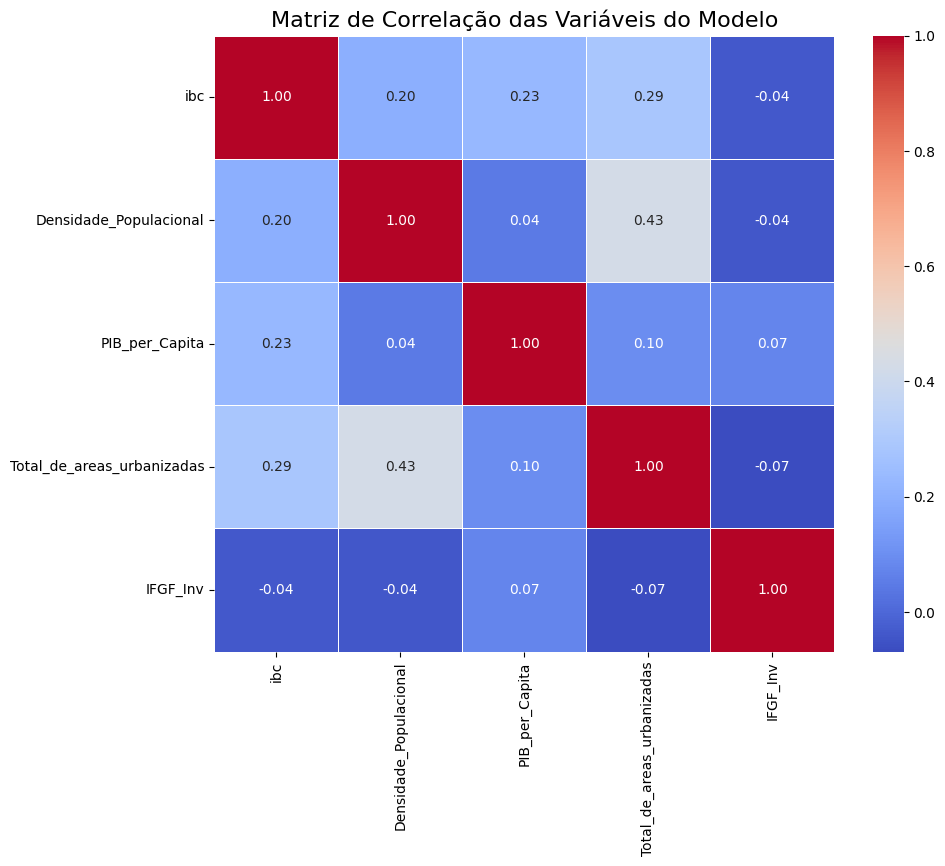

In [ ]:
#Criando uma matriz de correlação para visualização de possiveis multicolinearidade
variaveis_do_modelo = [
    'ibc',
    'Densidade_Populacional',
    'PIB_per_Capita',
    'Total_de_areas_urbanizadas',
    'IFGF_Inv'
]
df_modelo = df_r1[variaveis_do_modelo]
matriz_correlacao = df_modelo.corr()
print("\n--- Matriz de Correlação ---")
plt.figure(figsize=(10, 8))
sns.heatmap(
    matriz_correlacao,
    annot=True,          
    cmap='coolwarm',     
    fmt='.2f',           
    linewidths=.5        
)

plt.title('Matriz de Correlação das Variáveis do Modelo', fontsize=16)
plt.show()

**A Matriz de correlação aparentemente nos diz que não há uma multicolinearidade grande entre as variáveis do modelo**, contudo ainda sim cabe fazermos o teste mais formal e robusto por meio do calculo do Fator de Inflação da Variância (FIV)

In [ ]:
# Calculando o Fator de Inflação da Variância para testar a Multicolinearidade
from statsmodels.stats.outliers_influence import variance_inflation_factor

variaveis_independentes = df_r1[['Densidade_Populacional', 'PIB_per_Capita', 'Total_de_areas_urbanizadas', 'IFGF_Inv']]

variaveis_independentes['intercept'] = 1

vif = pd.DataFrame()
vif["variavel"] = variaveis_independentes.columns
vif["VIF"] = [variance_inflation_factor(variaveis_independentes.values, i) for i in range(variaveis_independentes.shape[1])]

print(vif)

                     variavel       VIF
0      Densidade_Populacional  1.221126
1              PIB_per_Capita  1.016173
2  Total_de_areas_urbanizadas  1.234647
3                    IFGF_Inv  1.011775
4                   intercept  4.773352


/tmp/ipykernel_86/1348640607.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Resultados e conclusões acerca da Terceira Regressão
* Após analisar a matriz de correlação das variáveis, bem como FIV podemos *descartar a presença de multicolinearidade do nosso modelo*, uma vez que na matriz de correlação não possuímos correlações dois a dois entre as variáveis maiores do que 0.6, bem como no FIV todas as variáveis apresentaram valores próximos de 1 o que acaba descartando esse fator do modelo.
* Com a possibilidade de multicolinearidade descartada, o valor negativo das variáveis IFGF_Inv se deve a alguma dinâmica que contraria o pressuposto inicial. Dessa forma, podemos criar um novo pressuposto que se baseia na seguinte concepção acerca dos investimentos: Municípios que possuem um IBC pior, podem ter um indicador de IGFG maior, uma vez que é esperado que esses municípios tenham um maior gasto no investimento e recebam até mesmo dinheiro do governo federal para o mesmo, além disso, cidades que possuem um IBC mais consolidado gastem menos em investimentos e sim mais renda em salários e direcionar parte da receita do município para cobrir gastos com a depreciação e manutenção da infraestrutura já existente.
* Contudo, nosso modelo ainda carece de muitas variáveis explicativas que seriam relevantes ao modelo, um indicador disso é o R-quadrado extremamente baixo, *desse modo não podemos descartar a possibilidade de viés de variável omitida*
* Dessa forma, eu estudos futuros sobre o tema, sabemos que a Densidade populacional, o PIB per Capita, o Total de Areas urbanizadas e indicadores de investimentos do município são relevantes para explicar o IBC, contudo somente estes ainda são insuficientes, logo cabendo ao pesquisador ou analista de mercado, mais variáveis e dados: tais como distancia do município de uma capital, uma vez que é mais fácil levar conectividade para cidades que estão em um entorno de um HUB de tecnologia, altitude de cada município, pois também é mais fácil levar conexões como fibra óptica para cidades com baixa altitude, outros fatores também podem ser descritos como sociais, por exemplo cidades com população mais idosa tem menos necessidade de tecnologia, bem como muitas dessas pessoas não vejam utilidade para conexão mais rápida, dado que elas não tem a tecnologia tão integrada em seu dia a dia

# **Conclusões Gerais do Estudo**
* As regiões que possuíram os melhores indicadores de conectividade são justamente as regiões Sul e Sudeste, com no caso do principal indicador, o IBC, essas regiões liderando com folga se comparado com outras regiões do país, além disso, vimos que a região Norte é a obteve os indicadores mais baixos, evidenciando-se o indicador geral e principal o IBC, isso justamente se deve ao fato de a região Norte sofrer com baixa infraestrutura no geral, bem como ter poucos polos de concentração de indústrias ou sedes de empresas de serviços na região, se comparado com o Sul e Sudeste. A exceção é para as capitais do País, uma vez que a maioria das capitais obtiveram IBC's bem maiores que a média do Brasil.
* As coberturas 4G/5G na maior parte das regiões estão avançando, com o Brasil tendo uma cobertura satisfatória, contudo vale ressaltar que muito desse indicador ter valores positivos se deu ao fato de a ANATEL considerar a cobertura tanto do 4G quanto do 5G de maneira unida, dessa forma caso houvesse a distinção entre as duas tecnologias provavelmente teríamos uma cobertura 5G ainda muito abaixo. Porém, com base neste indicador podemos dizer que a maioria das regiões está com coberturas satisfatórias, com exceção da região norte.
* No que tange a cobertura de Fibra (FTTH) a nossa conclusão é que as Regiões Sul e Sudeste estão com coberturas satisfatórias, bem como as regiões Norte e Nordeste são as que possuem as piores coberturas de fibra
* O HHI nos revelou somente uma dinâmica já conhecida a da extrema concentração de mercado no país no setor de telecomunicações, isso se da, pois o mercado principalmente de telefonia móvel no Brasil é um Oligopólio, dessa forma todas as regiões obtiveram HHI's altos o que indicam alta concentração de mercado. O único fato curioso é que até mesmo as capitais apresentaram alta concentração de mercado, algo que não era tão esperado, uma vez que ao menos na fibra haveria mais competição entre as empresas de telefonia, porém isso não deve ocorrer, pois por mais que na fibra haja mais empresas disponibilizando serviços, o mercado ainda está concentrado na mão de poucas empresas tais como Vivo, Claro e Oi
* Por fim, nossa regressão se mostrou insuficiente para determinar explicar toda a dinâmica que afeta o IBC, dessa forma não podendo ser usada para predizer os valores do IBC, porém ela é reveladora ao todas as variáveis presentes na regressão serem significativas a 5% de significância, o que como foi dito na seção anterior as variáveis como densidade populacional, PIB per capita, indicadores de investimento e total de áreas urbanas são relevantes para explicar a dinâmica do IBC.